# STOCHASTIC CLIMATE EMULATORS FOR COASTAL HAZARDS
### UCSC - Nov 2024


<img src="images/Image_3.png" alt="Texto alternativo" width="400">  


## TESLA: 02 - ANNUAL WEATHER TYPES



---

Fernando J.Mendez (fernando.mendez@unican.es)

Full Profesor at the Univeristy of Cantabria

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, University of Cantabria

<img src="images/Image_1.png" alt="Texto alternativo" width="200">               <img src="images/Image_2.jpeg" alt="Texto alternativo" width="200">

<img src="images/Image_4.jpeg" alt="Texto alternativo" width="800"> 

© GeoOcean 2024 - University of Cantabria


---

Inputs required:
  * Sea Level Pressure (Predictor) (ERA-5)
  * Storm Surge data (Predictant) (CoDEC)
  * Wave data (Predictant) (CAWCR)

  

  
In this notebook:
  1. Import required libraries and paths
  2. Annual Weather Type (AWT) Obtention
  3. Principal Component Analysis (PCA)
  4. K-MEANS Classification
  5. Save data 


---

## **1. Import required libraries and paths**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
import numpy as np
import xarray as xr
import os
import os.path as op
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math

In [2]:
# paths
p_dat = ('/workspaces/TESLA_UCSC/data')
p_out = ('/workspaces/TESLA_UCSC/results')

---

## **2. AWT OBTENTION**

In [3]:
clusters=25
n = math.sqrt(clusters)
n = int(n)
n

5

In [4]:
DailyPCs = xr.open_dataset(op.join(p_out, 'SLP_KMA.nc'))

In [5]:
s1=np.full([len(np.unique(DailyPCs.cluster)),len(np.unique(DailyPCs.time.dt.year))],np.nan)

# Natural year !!!!
for i in range(len(np.unique(DailyPCs.time.dt.year))):
    s=np.where(DailyPCs.time.dt.year==np.unique(DailyPCs.time.dt.year)[i])
    for j in range(len(np.unique(DailyPCs.cluster.values))):
        s1[j,i]=len(np.where(DailyPCs.cluster.values[s]==j)[0])/len(s[0])

annual_prob = xr.Dataset({'prob': (['dwt','year'],s1)},
             coords={'year': np.unique(DailyPCs.time.dt.year), 'dwt': np.unique(DailyPCs.cluster)})

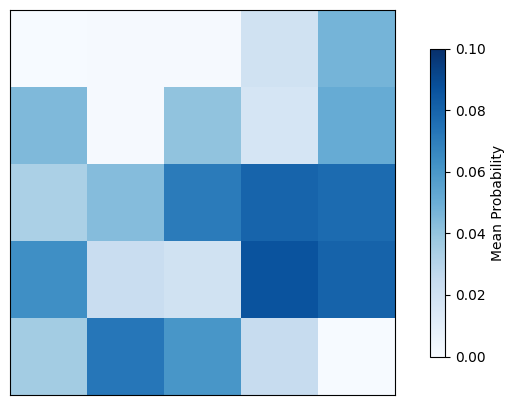

In [6]:
fig = plt.figure(figsize=[9,5])
gs2=gridspec.GridSpec(1,1)
ax2=fig.add_subplot(gs2[0])
im = ax2.pcolormesh(np.flipud(annual_prob.mean(dim='year').prob.values.reshape(n,n)),cmap='Blues',vmin=0, vmax=.1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal')

plt.colorbar(im, ax = ax2, shrink = .8).set_label('Mean Probability')

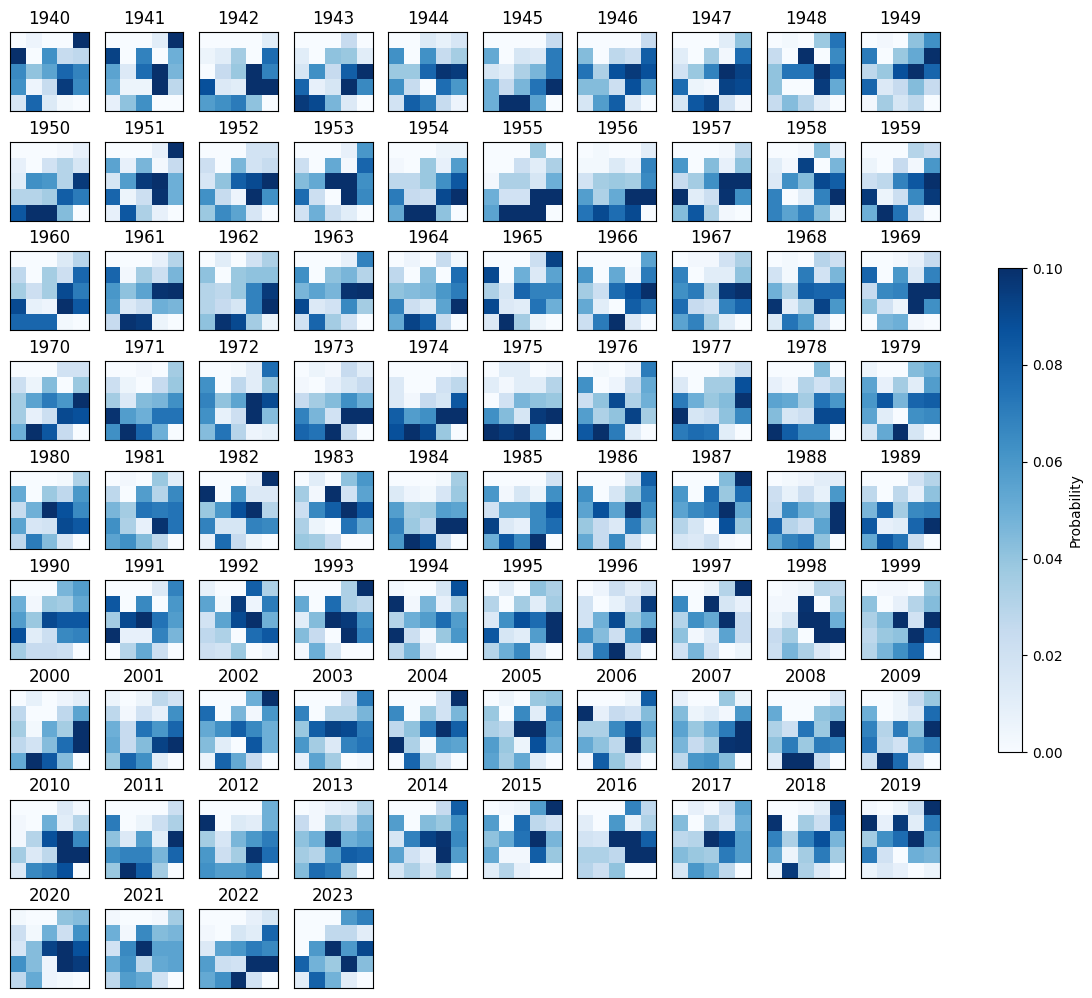

In [7]:
nyears = len(np.unique(annual_prob.year))
fig = plt.figure(figsize=[15,14])
gs2=gridspec.GridSpec(int(np.ceil(np.sqrt(nyears))),int(np.ceil(np.sqrt(nyears))))

AXS = []
for iy, year in enumerate(np.unique(annual_prob.year)):

    ax = fig.add_subplot(gs2[iy])
    im = ax.pcolormesh(np.flipud(annual_prob.sel(year = year).prob.values.reshape(n,n)),cmap='Blues',vmin=0, vmax=.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title('{}'.format(year))
    AXS.append(ax)

plt.colorbar(im, ax = AXS, shrink = .5).set_label('Probability')

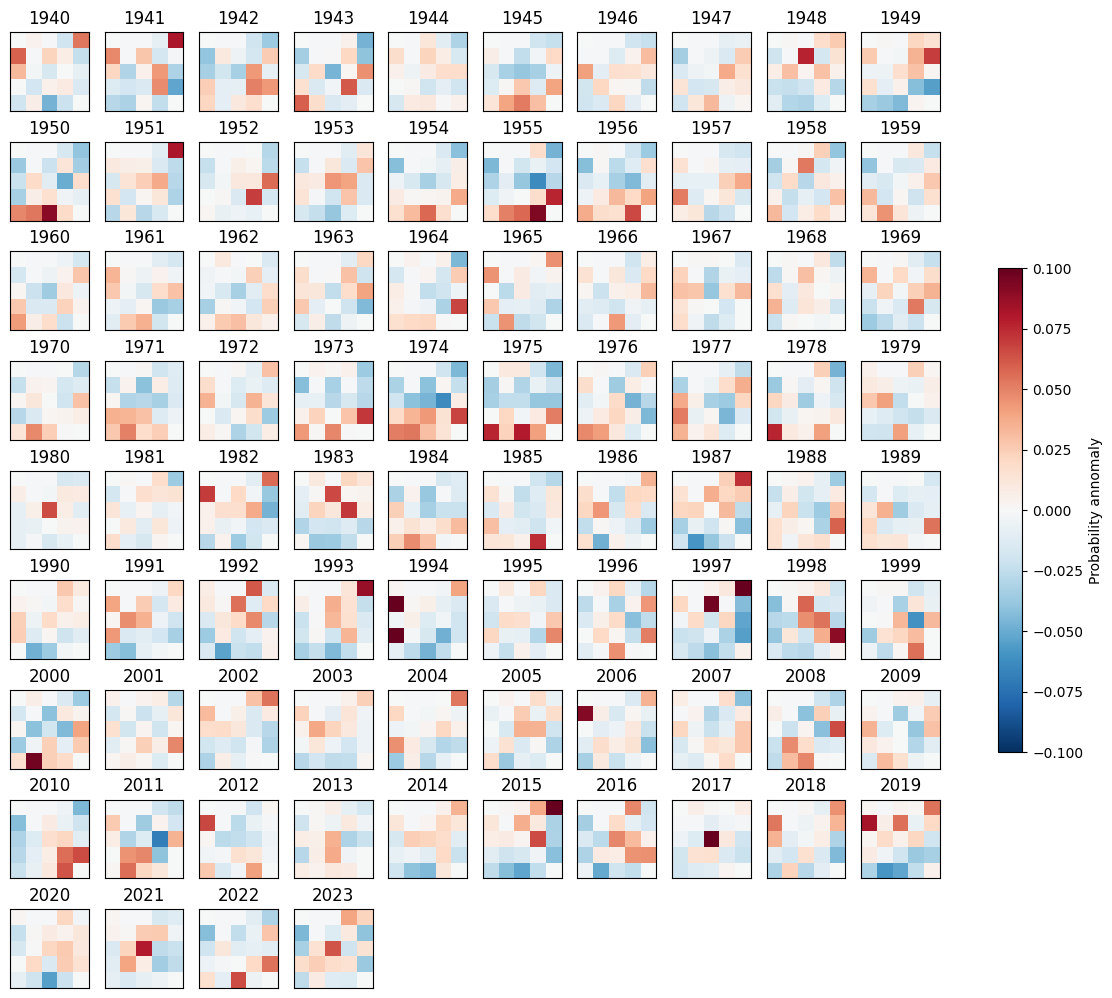

In [8]:
nyears = len(np.unique(annual_prob.year))
fig = plt.figure(figsize=[15,14])
gs2=gridspec.GridSpec(int(np.ceil(np.sqrt(nyears))),int(np.ceil(np.sqrt(nyears))))

year = 2010
AXS = []
for iy, year in enumerate(np.unique(annual_prob.year)):

    ax = fig.add_subplot(gs2[iy])
    im = ax.pcolormesh(np.flipud(annual_prob.sel(year = year).prob.values.reshape(n,n)) - np.flipud(s1.mean(axis=1).reshape(n,n)),
                  cmap='RdBu_r',vmin=-.1, vmax=.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title('{}'.format(year))
    AXS.append(ax)

plt.colorbar(im, ax = AXS, shrink = .5).set_label('Probability annomaly')


---

## **3. PRINCIPAL COMPONENT ANALYSIS (PCA)**

In [9]:
pca = PCA()
principalComponents = pca.fit_transform(s1.T)
eofs=pca.components_ #(n_pcs, n_features)
ev=pca.explained_variance_ratio_

x=np.flipud(range(0, 6))

In [10]:
pcs_95 = len(np.where(np.cumsum(ev)*100<95)[0])
print('Number of PCs explaining 95% of the explained variance is: {0}'.format(pcs_95))

Number of PCs explaining 95% of the explained variance is: 13


---

## **3.Principal Component Analysis (PCA)**

In [11]:
# For this example:
n_pcs = 3
n_clusters = 5

In [12]:
kmeans = KMeans(n_clusters,init='k-means++',random_state=0)

data = principalComponents[:,:n_pcs]

awt_bmus = kmeans.fit_predict(data)

yy=np.unique(DailyPCs.time.dt.year)

In [13]:
years = np.unique(DailyPCs.time.dt.year)

In [14]:
times = np.array([f"{year}-01-01" for year in years], dtype='datetime64[ns]')

pcs_awt = xr.Dataset({'PCs': (['time','n_pcs'],principalComponents[:,0:n_pcs]),'AWT': (['time'],awt_bmus)},
                     coords={'time': times, 'n_pcs': range(n_pcs)})

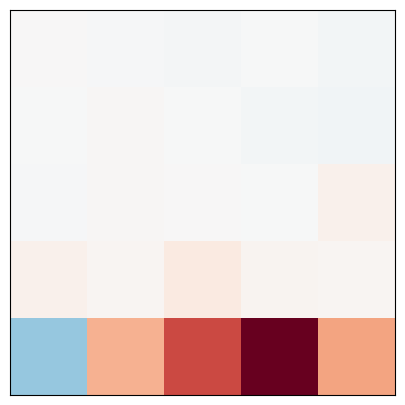

In [15]:
eof_n = 0

fig = plt.figure(figsize=[10,5])
gs2=gridspec.GridSpec(1,1)
ax2=fig.add_subplot(gs2[0])
ax2.pcolormesh(np.flipud((eofs[:,eof_n].reshape(5,5))),cmap='RdBu_r',vmin=-0.5, vmax=0.5)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal')

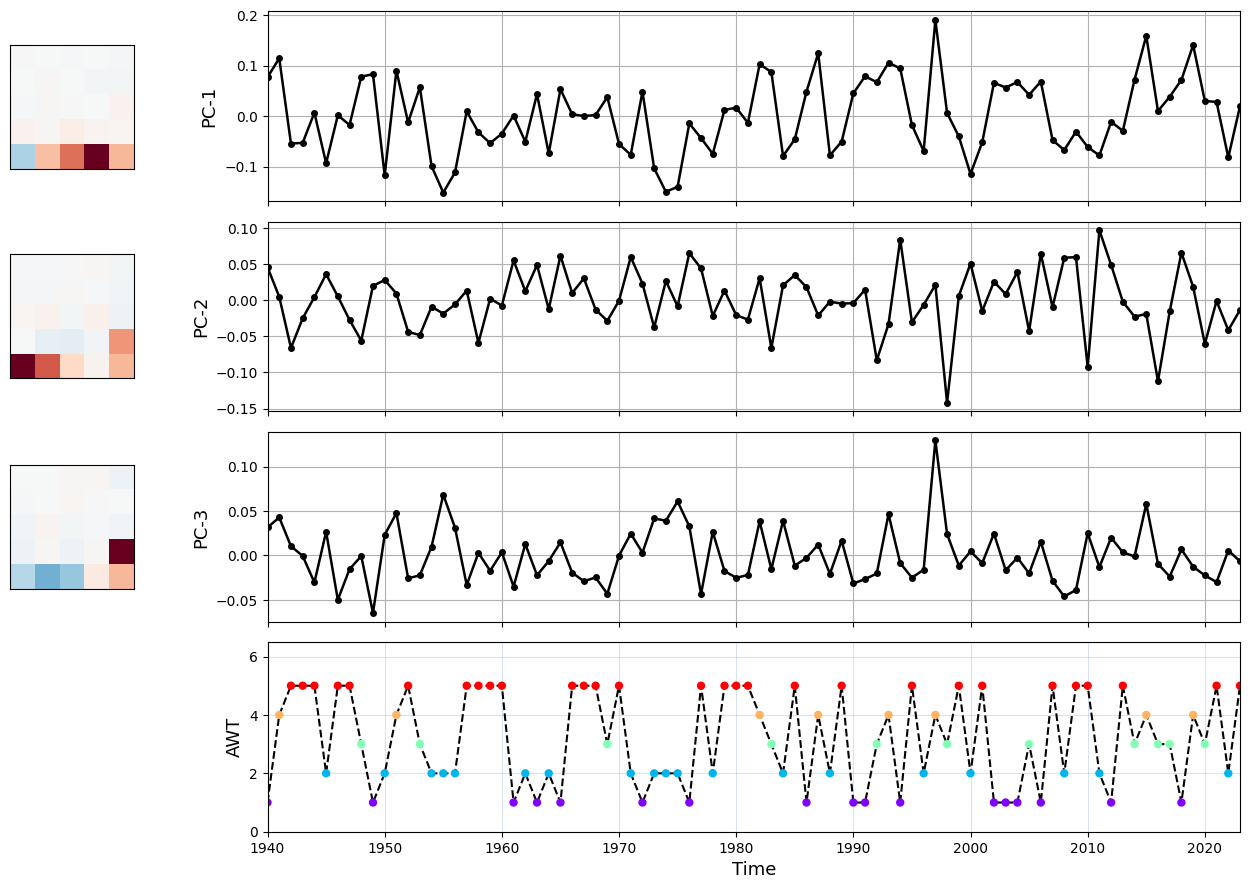

In [16]:
fig = plt.figure(figsize=[14,9])
gs2=gridspec.GridSpec(n_pcs+1,1)

for nn in range(n_pcs):
    ax2=fig.add_subplot(gs2[nn])
    ax2.plot(np.unique(DailyPCs.time.dt.year),principalComponents[:,nn],'k.-',linewidth=1.8,markersize=8)


    ax2.set_ylabel('PC-'+str(nn+1),fontsize=13)
    ax2.grid('minor')
    ax2.set_xticklabels([])
    ax2.set_xlim([np.unique(DailyPCs.time.dt.year)[0], np.unique(DailyPCs.time.dt.year)[-1]])


ax2=fig.add_subplot(gs2[nn+1])
ax2.plot(np.unique(DailyPCs.time.dt.year),awt_bmus+1,'k--',linewidth=1.5)
ax2.scatter(np.unique(DailyPCs.time.dt.year),awt_bmus+1, c=awt_bmus+1, s=25, cmap = 'rainbow', zorder=2)
ax2.grid('minor', color = 'royalblue', alpha = .2)
ax2.set_xlabel('Time',fontsize=13)
ax2.set_ylabel('AWT',fontsize=13)
ax2.set_ylim([0,6.5])
ax2.set_xlim([np.unique(DailyPCs.time.dt.year)[0], np.unique(DailyPCs.time.dt.year)[-1]])
#    plt.legend(fontsize=11,loc=2)


gs2.tight_layout(fig, rect=[0.22, [], 0.99, []])

gs3=gridspec.GridSpec(n_pcs+1,1)
for mm in range(n_pcs):
    ax3=fig.add_subplot(gs3[mm])
    ax3.pcolormesh(np.flipud((eofs[:,mm].reshape(n,n))),cmap='RdBu_r',vmin=-0.6, vmax=0.6)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_aspect('equal')

gs3.tight_layout(fig, rect=[0.09, 0.05, 0.2, []])

In [17]:
np.unique(awt_bmus+1, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32), array([17, 19, 11,  8, 29]))

Text(0, 0.5, 'Number of years')

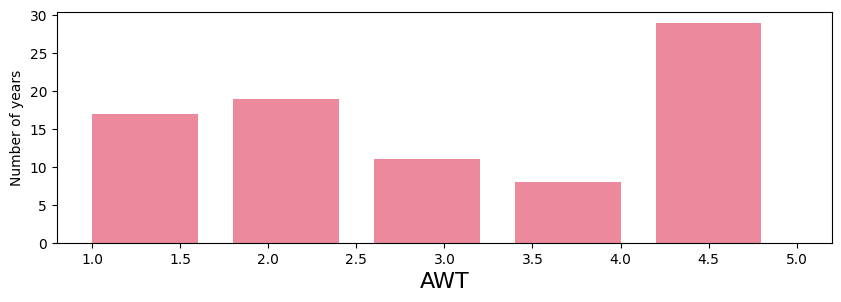

In [18]:
plt.figure(figsize = [10, 3])
plt.hist(awt_bmus+1, bins = n_clusters, width = .6, color = 'crimson', alpha = .5)
plt.xlabel('AWT', fontsize = 16)
plt.ylabel('Number of years')

In [19]:
np.unique(awt_bmus+1, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32), array([17, 19, 11,  8, 29]))

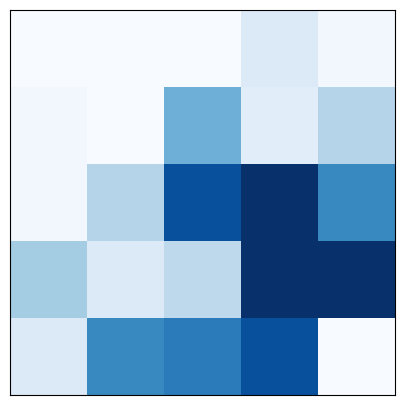

In [20]:
year = 2010

# plt.figure()
# plt.pcolormesh(np.rot90((eofs[:,0].reshape(6,6))),cmap='RdBu_r',vmin=-0.5, vmax=0.5)
eof_n = 0

fig = plt.figure(figsize=[9,5])
gs2=gridspec.GridSpec(1,1)
ax2=fig.add_subplot(gs2[0])
ax2.pcolormesh(np.flipud(annual_prob.sel(year = year).prob.values.reshape(n,n)),cmap='Blues',vmin=0, vmax=.1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal')

Text(0.5, 1.0, 'Ncomponents= 3')

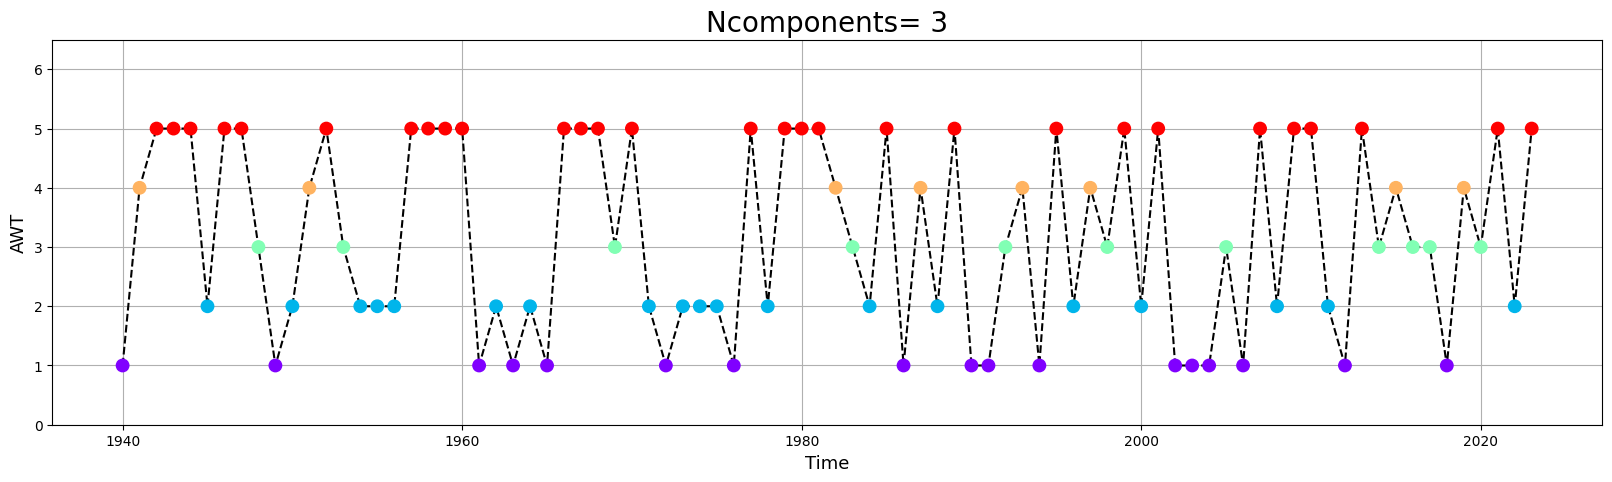

In [21]:
fig = plt.figure(figsize=[20,5])
ax2=fig.add_subplot()
ax2.plot(np.unique(DailyPCs.time.dt.year),awt_bmus+1,'k--', linewidth=1.5,markersize=10,color='black')
ax2.scatter(np.unique(DailyPCs.time.dt.year),awt_bmus+1, c=awt_bmus+1, s=80, cmap = 'rainbow', zorder=2)


ax2.grid('minor')
ax2.set_xlabel('Time',fontsize=13)
ax2.set_ylabel('AWT',fontsize=13)
ax2.set_ylim([0,6.5])
plt.title('Ncomponents= ' + str(n_pcs), fontsize = 20)

---

## **5. SAVE DATA**

In [24]:
pcs_awt.to_netcdf(op.join(p_out, 'AWT_PCs_from_DWT.nc'))